In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.
/Users/noe/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [22]:
def test_sample(network, temperature=1.0):
    sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=100000)
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(5, 4))
    _, E = double_well.plot_dimer_energy(temperature=temperature)
    h, b = np.histogram(sample_x[:, 0], bins=100)
    Eh = -np.log(h) / temperature
    Eh = Eh - Eh.min() + E.min()
    bin_means = 0.5*(b[:-1] + b[1:])
    plt.plot(bin_means, Eh)
    return bin_means, Eh

In [7]:
# reweighting
def test_sample_rew(network, temperature=1.0):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(5, 4))
    double_well.plot_dimer_energy()
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [8]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [9]:
def getx(x):
    return x[:, 0]

Double well
---

In [10]:
paper_dir = '/Users/noe/data/papers/Noe_BoltzmannGenerators_LatentMCMC/'

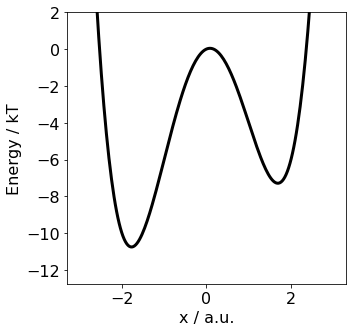

In [11]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();
plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

In [12]:
print(params)

{'dim': 2, 'a2': 6.0, 'a4': 1.0, 'a1': 1.0, 'k': 1.0}


In [13]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [16]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

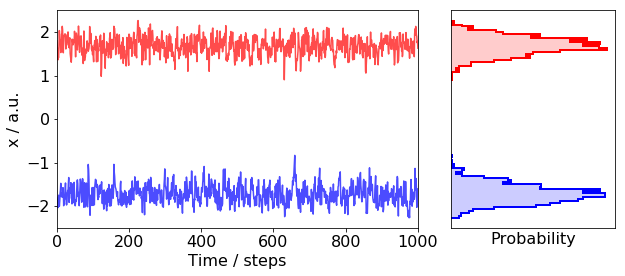

In [17]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('x / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')
plt.savefig(paper_dir + 'figs/doublewell_prior_trajs.pdf', bbox_inches='tight')

In [18]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [19]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

In [38]:
# just for visualization
sampler_long = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler_long.run(100000)
traj_left_long = sampler_long.traj

Validate Umbrella Sampling + BAR
------

In [14]:
from deep_boltzmann.sampling import MetropolisGauss, UmbrellaSampling

In [307]:
sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
def rc_x(x):
    return x[:, 0]
us = UmbrellaSampling(double_well, sampler, rc_x, x0_left, 20, 50, -2.5, 2.5, forward_backward=True)
us.run(25000)

Umbrella 1 / 40
Umbrella 2 / 40
Umbrella 3 / 40
Umbrella 4 / 40
Umbrella 5 / 40
Umbrella 6 / 40
Umbrella 7 / 40
Umbrella 8 / 40
Umbrella 9 / 40
Umbrella 10 / 40
Umbrella 11 / 40
Umbrella 12 / 40
Umbrella 13 / 40
Umbrella 14 / 40
Umbrella 15 / 40
Umbrella 16 / 40
Umbrella 17 / 40
Umbrella 18 / 40
Umbrella 19 / 40
Umbrella 20 / 40
Umbrella 21 / 40
Umbrella 22 / 40
Umbrella 23 / 40
Umbrella 24 / 40
Umbrella 25 / 40
Umbrella 26 / 40
Umbrella 27 / 40
Umbrella 28 / 40
Umbrella 29 / 40
Umbrella 30 / 40
Umbrella 31 / 40
Umbrella 32 / 40
Umbrella 33 / 40
Umbrella 34 / 40
Umbrella 35 / 40
Umbrella 36 / 40
Umbrella 37 / 40
Umbrella 38 / 40
Umbrella 39 / 40
Umbrella 40 / 40


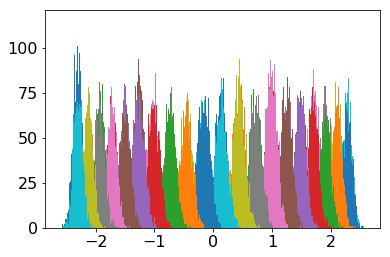

In [308]:
for rc_traj in us.rc_trajs:
    plt.hist(rc_traj, 100);

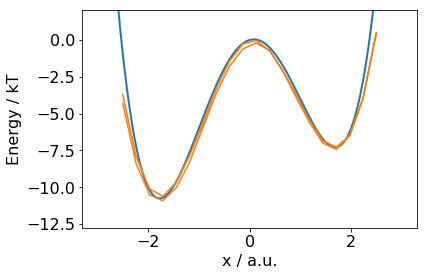

In [312]:
double_well.plot_dimer_energy();
plt.plot(us.umbrella_positions, us.umbrella_free_energies()-4.3)

Training
-------

In [20]:
def train(network, epochsZ=200, epochsE=0, wML=1.0, wKL=1.0, wW2=0.0, wRC=0.0, temperature=1.0, explore=1.0):
    # pretrain
    hist = network.train_ML(x, xval=xval, epochs=epochsZ, batch_size=128, std=1.0, verbose=0)
    
    # train
    plt.figure()  # figure for loss
    if epochsE > 0:
        nterms = 0
        if wML > 0:
            nterms +=1
        if wKL > 0:
            nterms +=1
        if wW2 > 0:
            nterms +=1
        if nterms == 1 and wKL > 0:
            hist2 = network.train_KL(lr=0.001, epochs=epochsE, batch_size=2048, explore=explore, verbose=0)
            plt.plot(hist2)
        else:
            hist2 = network.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, batch_size=2048, std=1.0,
                                           weight_ML=wML, weight_KL=wKL, weight_MC=0.0, weight_W2=wW2,
                                           weight_RCEnt=wRC, rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                           temperature=temperature, explore=explore, verbose=0)
            for i in range(nterms):
                plt.plot(hist2[1][:, i+1])
                plt.plot(hist2[2][:, i+1])
    else:
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
    
    print('std_z', network.std_z(x))
    print('std_z_val', network.std_z(xval))
    
    # plot densities
    fig, axes = test_xz_projection(network.Txz, [traj_left, x_ts, traj_right], 
                                   rctrajs=[traj_left[:, 0], x_ts[:, 0], traj_right[:, 0]],
                                   colors=['blue', 'orange', 'red']);
    axes[1].set_xlim(-5, 5)
    axes[1].set_ylim(-5, 5) 
    
    # plot sample
    test_sample(network)
    test_sample_rew(network)

Train with ML + KL
-------

std_z 1.1428338
std_z_val 1.3016021


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


Estimator Standard Error:  0.7616112780667013


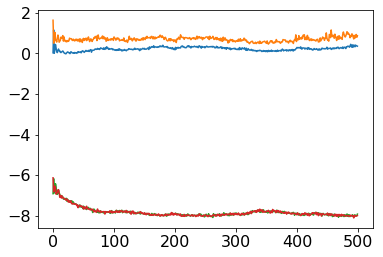

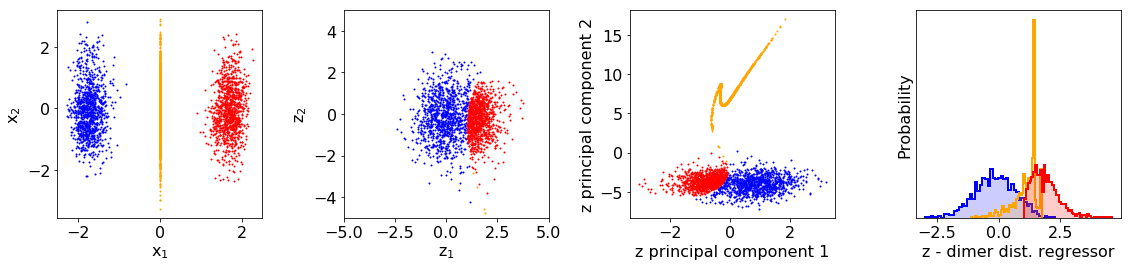

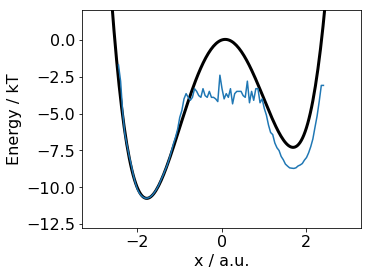

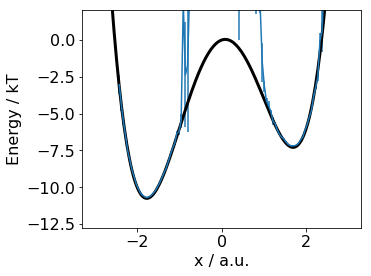

In [46]:
network_RealNVP_KLML = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLML, epochsZ=200, epochsE=500, wML=1.0, wKL=1.0, wW2=0.0, explore=1.0)

Latent MCMC
-----

In [49]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0], color='orange', linewidth=1)
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    _, Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min(), color='orange', linewidth=2)
    return fig, axes

Transitions: 5530


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


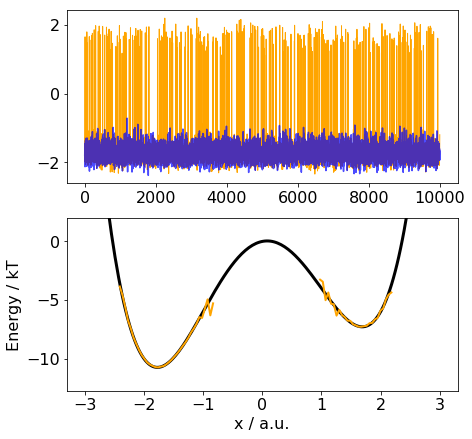

In [53]:
fig, axes = test_mcmc(network_RealNVP_KLML, 100000)
axes[0].plot(traj_left_long[:, 0], color='blue', alpha=0.7)
fig.savefig(paper_dir + 'figs/doublewell_KLML_LatentMCMC.pdf', bbox_inches='tight')

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'output_z_2/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_2/GatherV2:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'output_x_2/GatherV2:0' shape=(?, 2) dtype=float32>]
  ' Found: ' + str(self.outputs))


std_z 0.7967518
std_z_val 0.9074141


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


Estimator Standard Error:  0.1945735861121


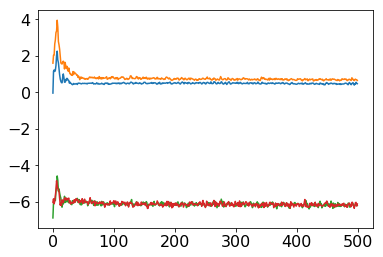

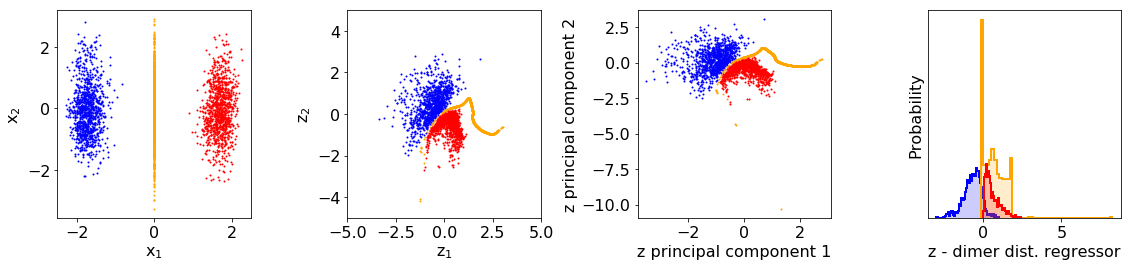

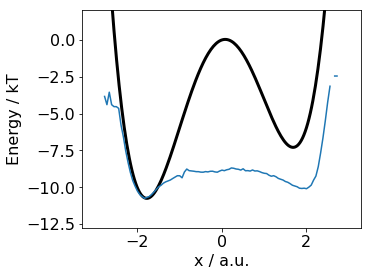

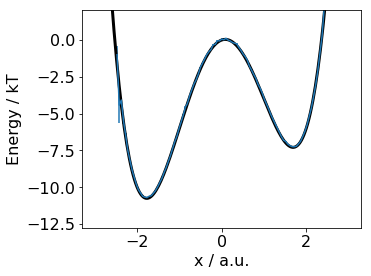

In [51]:
network_RealNVP_KLRC = create_RealNVPNet(double_well, nl_activation='tanh')
train(network_RealNVP_KLRC, epochsZ=200, epochsE=500, wML=0.001, wKL=1.0, wRC=1.0, explore=1.0)

Transitions: 2826


/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


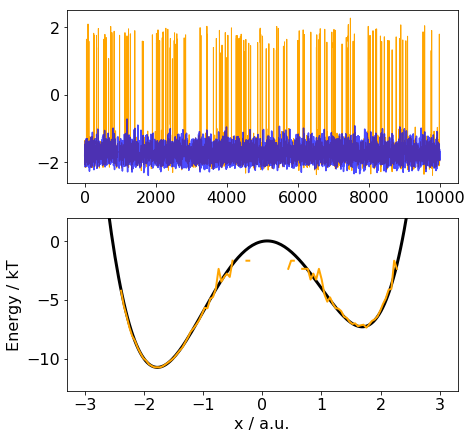

In [54]:
fig, axes = test_mcmc(network_RealNVP_KLRC, 100000)
axes[0].plot(traj_left_long[:, 0], color='blue', alpha=0.7)
fig.savefig(paper_dir + 'figs/doublewell_KLRC_LatentMCMC.pdf', bbox_inches='tight')

MCMC in latent space
-----

In [33]:
from deep_boltzmann.sampling.latent_sampling import LatentMetropolisGauss
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [26]:
lmg = LatentMetropolisGauss(network_RealNVP_KLML, np.array([[0, 0]]))

In [28]:
lmg.run(10000)

/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/sampling/analysis.py:112: RuntimeWarning: divide by zero encountered in log
  Es.append(-np.log(Psample))


<Container object of 3 artists>

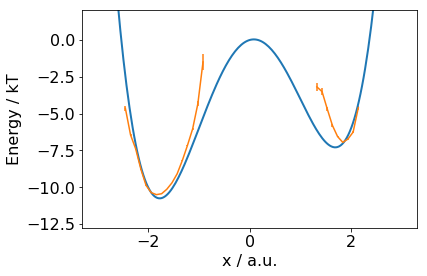

In [43]:
# plot reference
Edimer = double_well.plot_dimer_energy()
# plot estmiated PMF
bins, Es = free_energy_bootstrap(lmg.trajs[0][:, 0], -2.5, 2.5, 50)
Emean = mean_finite(Es, axis=0)
Estd = std_finite(Es, axis=0)
plt.errorbar(bins, Emean-Emean[np.isfinite(Emean)].min()-10.5, Estd)

**Note:** This is not correct because this sampling algorithm has not been updated for RealNVP yet. Needs to be fixed if we need this algorithm.